# Overlap Analysis

In this file we use the formated datasets of krill pop and mean sequestration time to performe the overlap analysis and identify the different zine typology, including the Key Areas for Krill carbon Sequetsration (KAKS).

Data used :
- for krill population : the krill_base_krillpodym.csv datasets which gather krillbase and krillpodym data to define the upper tiertile of the krill density.
- for the time of sequestration it uses the formated OCIM outputs mean_time_seq_final


In [1]:
# import libraries
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
# To be change with local directory of the data (file too heavy to be on git)
import os
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration')
#os.chdir('./Key_Areas_krill_carbon_sequestration/outputs_formated_data/')

# Load data

In [3]:
# krill data 
krill_podym = pd.read_csv('./outputs_formated_data/Krill_biomass_df_final.csv')[['latitude', 'longitude', 'krill_adult_log']]
krill_podym = krill_podym[krill_podym['krill_adult_log'] != 0] # drop 0 (keep data on the actula distrib range of krill, "others are false zeros")
krill_podym = krill_podym.set_index(['latitude', 'longitude']).dropna()
krill_podym # 1890   rows

krill_adult_log
latitude longitude                 
-77      -179               0.57452
         -177               0.81818
         -175               1.00264
         -173               0.99747
         -171               1.14972
...                             ...
-45       63                0.00001
          65                0.00762
          67                0.10288
          69                0.05762
          71                0.00012

[1890 rows x 1 columns]

In [4]:
# time seq
mean_time_seq = xr.open_dataset('./outputs_formated_data/xr_mean_time_seq_final.nc')
mean_time_seq = mean_time_seq.rename_vars({'__xarray_dataarray_variable__' : 'mean_seq_time' })
mean_time_seq = mean_time_seq.to_dataframe().reset_index().drop(['variable'], axis=1).set_index(['latitude', 'longitude'])# 2880  rows × 3 columns
mean_time_seq =  mean_time_seq.dropna()
mean_time_seq # 2384 rows

mean_seq_time
latitude longitude               
-75      -179          646.910548
         -177          601.882341
         -175          655.238074
         -173          641.075711
         -171          620.753036
...                           ...
-45       167           -0.000000
          173          162.285177
          175          131.782475
          177          207.926560
          179          117.346934

[2384 rows x 1 columns]

# Overalp 

## Define 1/3 tile for the sequestration time
Select cells in the upper tiertile of the time seq distribution

In [5]:
seq_quantile = mean_time_seq['mean_seq_time'].quantile(q=[0.3333, 0.6666]) # 311.399158 ; 435.064221
seq_quantile

0.3333    311.399158
0.6666    435.064221
Name: mean_seq_time, dtype: float64

In [6]:
mean_time_seq['Upper_tiertile'] = [1 if x > seq_quantile.iloc[1] else 0 for x in mean_time_seq['mean_seq_time']]
mean_time_seq

mean_seq_time  Upper_tiertile
latitude longitude                               
-75      -179          646.910548               1
         -177          601.882341               1
         -175          655.238074               1
         -173          641.075711               1
         -171          620.753036               1
...                           ...             ...
-45       167           -0.000000               0
          173          162.285177               0
          175          131.782475               0
          177          207.926560               0
          179          117.346934               0

[2384 rows x 2 columns]

## define 1/3 tile for the krill density

To have a value (a density) of the the upper tier-tile threshold for the krill pop we retrived the tiertile based on Krillpodyl data for the graph; and krillbase for comparision

In [7]:
krill_quantile = krill_podym['krill_adult_log'].quantile(q=[0.3333, 0.6666])
krill_quantile

0.3333    1.09418
0.6666    1.59819
Name: krill_adult_log, dtype: float64

In [8]:
krill_podym['Upper_tiertile'] = [1 if x > krill_quantile.iloc[1] else 0 for x in krill_podym['krill_adult_log']]
krill_podym

krill_adult_log  Upper_tiertile
latitude longitude                                 
-77      -179               0.57452               0
         -177               0.81818               0
         -175               1.00264               0
         -173               0.99747               0
         -171               1.14972               0
...                             ...             ...
-45       63                0.00001               0
          65                0.00762               0
          67                0.10288               0
          69                0.05762               0
          71                0.00012               0

[1890 rows x 2 columns]

## Join krill and time seq datasets

Inner join the two datsets (we need only cells where both data are available). 
Then identify the three following combinations in the krill and time seq labels:
- upper tiertile of both krill and time seq = KAKS > label = 3
- upper tiertile of krill but not time seq = high krill zone = 2
- upper tiertile of time seq but not krill = high toime seq zone = 1

In [9]:
data = pd.merge(mean_time_seq, krill_podym, left_index=True, right_index=True, how='inner', suffixes=('_seq', '_krill'))
data # 1782  rows

mean_seq_time  Upper_tiertile_seq  krill_adult_log  \
latitude longitude                                                       
-75      -179          646.910548                   1          1.08086   
         -177          601.882341                   1          1.38079   
         -175          655.238074                   1          1.51197   
         -173          641.075711                   1          1.53273   
         -171          620.753036                   1          1.70495   
...                           ...                 ...              ...   
-45       63           320.323902                   0          0.00001   
          65           257.610200                   0          0.00762   
          67           238.034583                   0          0.10288   
          69           314.399618                   0          0.05762   
          71           306.357993                   0          0.00012   

                    Upper_tiertile_krill  
latitude longitude                        
-75      -179                          0  
         -177                          0  
         -175                          0  
         -173                          0  
         -171                          1  
...                                  ...  
-45       63                           0  
          65                           0  
          67                           0  
          69                           0  
          71                           0  

[1773 rows x 4 columns]

### Define the 3 categories

In [10]:
data.loc[((data['Upper_tiertile_krill']==1) & (data['Upper_tiertile_seq']==1)) , 'Zone_type'] = 3 # 151  rows
data.loc[((data['Upper_tiertile_krill']==1) & (data['Upper_tiertile_seq']==0)) , 'Zone_type'] = 2 # 49  rows
data.loc[((data['Upper_tiertile_krill']==0) & (data['Upper_tiertile_seq']==1)) , 'Zone_type'] = 1 # 412  rows
data.loc[((data['Upper_tiertile_krill']==0) & (data['Upper_tiertile_seq']==0)) , 'Zone_type'] = 0 
data

mean_seq_time  Upper_tiertile_seq  krill_adult_log  \
latitude longitude                                                       
-75      -179          646.910548                   1          1.08086   
         -177          601.882341                   1          1.38079   
         -175          655.238074                   1          1.51197   
         -173          641.075711                   1          1.53273   
         -171          620.753036                   1          1.70495   
...                           ...                 ...              ...   
-45       63           320.323902                   0          0.00001   
          65           257.610200                   0          0.00762   
          67           238.034583                   0          0.10288   
          69           314.399618                   0          0.05762   
          71           306.357993                   0          0.00012   

                    Upper_tiertile_krill  Zone_type  
latitude longitude                                   
-75      -179                          0        1.0  
         -177                          0        1.0  
         -175                          0        1.0  
         -173                          0        1.0  
         -171                          1        3.0  
...                                  ...        ...  
-45       63                           0        0.0  
          65                           0        0.0  
          67                           0        0.0  
          69                           0        0.0  
          71                           0        0.0  

[1773 rows x 5 columns]

# Plot

<Figure size 800x800 with 0 Axes>

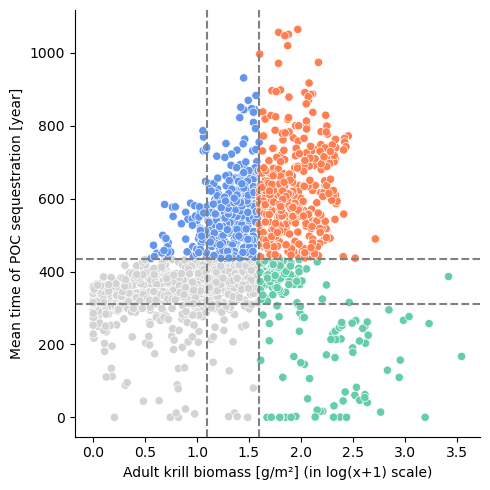

In [11]:
fig = plt.figure(figsize=(8, 8)) 

sns.relplot(x="krill_adult_log", y="mean_seq_time", 
            data=data.sort_values(by='Zone_type'),# sort to improve lisibility
            hue='Zone_type', 
            palette = ['lightgrey', 'cornflowerblue', 'mediumaquamarine', 'coral'],
            sizes = (15,75),
            legend=False)


plt.axvline(x=krill_quantile.iloc[0], color='grey', linestyle='--')
plt.axvline(x=krill_quantile.iloc[1], color='grey', linestyle='--')

plt.axhline(y=seq_quantile.iloc[0], color='grey', linestyle='--')
plt.axhline(y=seq_quantile.iloc[1], color='grey', linestyle='--')

plt.xlabel('Adult krill biomass [g/m²] (in log(x+1) scale)')
plt.ylabel('Mean time of POC sequestration [year]')

# plt.text(3.8, 400, '--- :  1/3 quantiles')

# saving in 'figure' folder
plt.tight_layout()
# plt.savefig('./figures/bi_plot_zones_typo.png', bbox_inches='tight', dpi=300)

plt.show()


# Map

In [17]:
# set index here with all coordinates
# make dataset with coordinates
coords = pd.DataFrame({'latitude':np.repeat(np.arange(-75, -45, 2), 180), # -75 to -51
                       'longitude': np.tile(np.arange(-179, 180, 2), 15), # -179 to 179
                       'label_grid': np.zeros(2700)}).set_index(['latitude', 'longitude'])

coords = coords.sort_values(['latitude', 'longitude'])

# merge
zones_data_complete = coords.join(data, how='left')

# transform in xarray
zones_array = xr.Dataset.from_dataframe(zones_data_complete[['Zone_type']]) # convert into xarrayDataset
zones_array = xr.Dataset.to_array(zones_array)
zones_array = zones_array.where(zones_array.latitude < -50, drop=True)
zones_array

<xarray.DataArray (variable: 1, latitude: 13, longitude: 180)>
array([[[ 1.,  1.,  1., ...,  2.,  3., nan],
        [ 1.,  1.,  3., ...,  3.,  1., nan],
        [ 3.,  1.,  1., ...,  1.,  1., nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * latitude   (latitude) int32 -75 -73 -71 -69 -67 -65 ... -59 -57 -55 -53 -51
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
  * variable   (variable) object 'Zone_type'

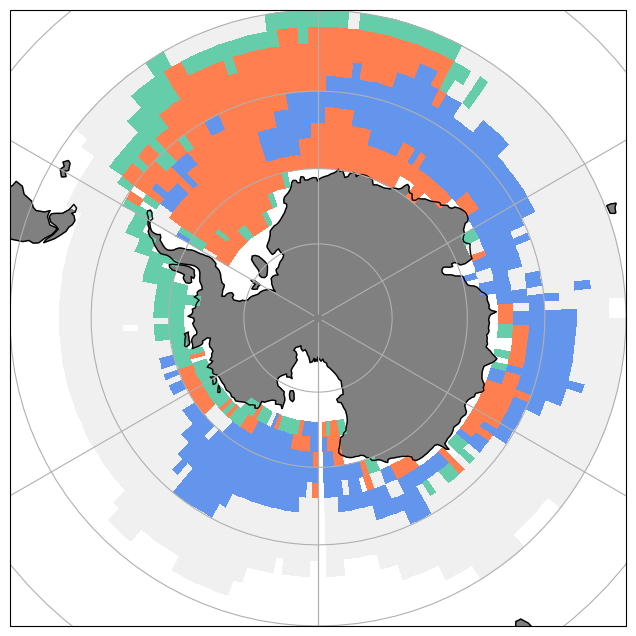

In [41]:
fig = plt.figure(figsize=(8, 8))

map_proj = ccrs.SouthPolarStereo()

p = zones_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj}, # the plot's projection
    levels=[1, 2, 3, 4], 
    colors = ['#f0f0f0', 'cornflowerblue', 'mediumaquamarine', 'coral']
)  


### Add features:
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
plt.title('')

# save
#os.chdir('./Key_Areas_krill_carbon_sequestration/figures/')
# plt.savefig('./figures/map_zone_types.png',bbox_inches='tight', dpi=300)

plt.show(p)

# Save

In [14]:
os.getcwd()

'C:\\Users\\anael\\Documents\\PhD\\4_krill_fisheries_Carbon_seq_time\\Git_repo\\Key_Areas_krill_carbon_sequestration'

In [20]:
zones_array

<xarray.DataArray (variable: 1, latitude: 13, longitude: 180)>
array([[[ 1.,  1.,  1., ...,  2.,  3., nan],
        [ 1.,  1.,  3., ...,  3.,  1., nan],
        [ 3.,  1.,  1., ...,  1.,  1., nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * latitude   (latitude) int32 -75 -73 -71 -69 -67 -65 ... -59 -57 -55 -53 -51
  * longitude  (longitude) int32 -179 -177 -175 -173 -171 ... 173 175 177 179
  * variable   (variable) object 'Zone_type'

In [16]:
# Save the dataframe 
# zones_data_complete.to_csv('./output_results/zones_krill_carbon.csv')
# save the xarray
# zones_array.to_netcdf('./output_results/zones_krill_carbon.nc')

# Area calculation
- Area of each zone type
  
The area of cell depends on latitude => this is stored for all cells (land and ocean) in 'AREA'
Then, the MASK is used to keep only the cells in the ocean (1 = ocean, 0= land, or proportion of the two)



In [21]:
# load area file from OCIM
OCIM = xr.open_dataset('./outputs_formated_data/fseq_OCIM2_48L_interpolated_SO.nc')
OCIM 

<xarray.Dataset>
Dimensions:        (ocean grid point: 405386, time: 1001, latitude: 20,
                    longitude: 180, depth: 48)
Coordinates:
  * longitude      (longitude) float64 -179.0 -177.0 -175.0 ... 177.0 179.0
  * depth          (depth) float64 4.935 14.88 25.12 ... 5.253e+03 5.582e+03
  * latitude       (latitude) int32 -79 -77 -75 -73 -71 ... -49 -47 -45 -43 -41
Dimensions without coordinates: ocean grid point, time
Data variables:
    fseq           (ocean grid point, time) float64 ...
    MASK           (latitude, longitude, depth) float64 ...
    LAT            (latitude, longitude, depth) float64 ...
    LON            (latitude, longitude, depth) float64 ...
    DEPTH          (latitude, longitude, depth) float64 ...
    VOL            (latitude, longitude, depth) float64 ...
    AREA           (latitude, longitude, depth) float64 ...
    mean_seq_time  (latitude, longitude, depth) float64 ...

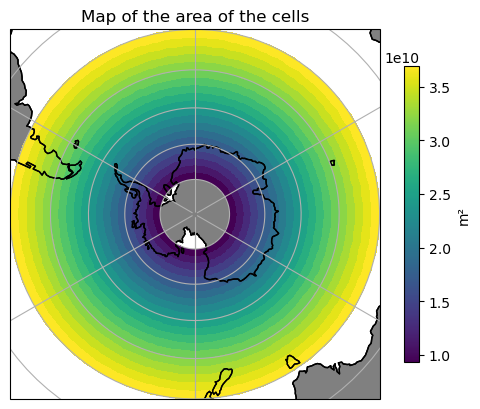

Text(0.5, 1.0, 'Map of the area of the cells')

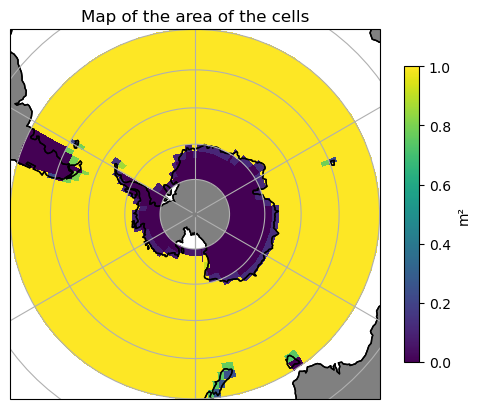

In [22]:
# select area
# note that the file is from -40°S
area = OCIM['AREA'].isel(depth=0) # area is in square meters

# Plot it
map_proj = ccrs.SouthPolarStereo()

p = area.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap="PuBu",
) 
p.axes.coastlines()
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'm²', shrink = 0.8)
plt.title('Map of the area of the cells')

plt.show()

mask = OCIM['MASK'].isel(depth=20)

map_proj = ccrs.SouthPolarStereo()

p = mask.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    #cmap="PuBu",
) 
p.axes.coastlines()
p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'm²', shrink = 0.8)
plt.title('Map of the area of the cells')

### Define "study area" as the ocean south of -45°

In [23]:
# transform area array into a dataframe and crop the file à -45°S
area_df = OCIM[['AREA', 'MASK']].isel(depth=0).to_dataframe().drop(['depth'], axis = 1).reset_index()
area_df = area_df[area_df['latitude'] <=-45].set_index(['latitude', 'longitude'])

## calculate the area of the ocean (remove land) => multiply be the proportion of the ocean in cell (= MASK : 1=ocean, 0=land, or %o each)
area_df['True_area'] = area_df['AREA']*area_df['MASK']
area_df # 3240  rows

AREA      MASK     True_area
latitude longitude                                      
-79      -179.0     9.332850e+09  0.061111  5.703408e+08
         -177.0     9.332850e+09  0.061111  5.703408e+08
         -175.0     9.332850e+09  0.061111  5.703408e+08
         -173.0     9.332850e+09  0.061111  5.703408e+08
         -171.0     9.332850e+09  0.061111  5.703408e+08
...                          ...       ...           ...
-45       171.0     3.458337e+10  0.750000  2.593752e+10
          173.0     3.458337e+10  1.000000  3.458337e+10
          175.0     3.458337e+10  1.000000  3.458337e+10
          177.0     3.458337e+10  1.000000  3.458337e+10
          179.0     3.458337e+10  1.000000  3.458337e+10

[3240 rows x 3 columns]

In [24]:
tot_area = area_df['True_area'].sum() 
tot_area #in m²  : from -45°S it is 62773577241920.17 = 6277 e+10 m² = 6277 e+4 km²

62773577241920.17

### Join to zones data 

In [25]:
zones_data_complete = zones_data_complete.join(other = area_df, how = 'left')
zones_data_complete #2700 

label_grid  mean_seq_time  Upper_tiertile_seq  \
latitude longitude                                                  
-75      -179              0.0     646.910548                 1.0   
         -177              0.0     601.882341                 1.0   
         -175              0.0     655.238074                 1.0   
         -173              0.0     641.075711                 1.0   
         -171              0.0     620.753036                 1.0   
...                        ...            ...                 ...   
-47       171              0.0            NaN                 NaN   
          173              0.0            NaN                 NaN   
          175              0.0            NaN                 NaN   
          177              0.0            NaN                 NaN   
          179              0.0            NaN                 NaN   

                    krill_adult_log  Upper_tiertile_krill  Zone_type  \
latitude longitude                                                     
-75      -179               1.08086                   0.0        1.0   
         -177               1.38079                   0.0        1.0   
         -175               1.51197                   0.0        1.0   
         -173               1.53273                   0.0        1.0   
         -171               1.70495                   1.0        3.0   
...                             ...                   ...        ...   
-47       171                   NaN                   NaN        NaN   
          173                   NaN                   NaN        NaN   
          175                   NaN                   NaN        NaN   
          177                   NaN                   NaN        NaN   
          179                   NaN                   NaN        NaN   

                            AREA  MASK     True_area  
latitude longitude                                    
-75      -179       1.265922e+10   1.0  1.265922e+10  
         -177       1.265922e+10   1.0  1.265922e+10  
         -175       1.265922e+10   1.0  1.265922e+10  
         -173       1.265922e+10   1.0  1.265922e+10  
         -171       1.265922e+10   1.0  1.265922e+10  
...                          ...   ...           ...  
-47       171       3.335547e+10   1.0  3.335547e+10  
          173       3.335547e+10   1.0  3.335547e+10  
          175       3.335547e+10   1.0  3.335547e+10  
          177       3.335547e+10   1.0  3.335547e+10  
          179       3.335547e+10   1.0  3.335547e+10  

[2700 rows x 9 columns]

In [26]:
# total surface of the study area (here the area defined in 'zone_krill_carbon')
tot_area_restricted = zones_data_complete['True_area'].sum()
tot_area_restricted # in m² 

56365167510303.7

## Area by zone type

In [27]:
# zone only high carbon seq but few/medium krill => label = 1
zones_1 = zones_data_complete[zones_data_complete['Zone_type'] == 1]
area_1 = zones_1['True_area'].sum() # in  m²
prop_1 = area_1/tot_area_restricted #

# zone only high krill => label = 2
zones_2 = zones_data_complete[zones_data_complete['Zone_type'] == 2]
area_2 = zones_2['True_area'].sum() # in m²
prop_2 = area_2/tot_area_restricted # 

# zone both high carbon seq and high krill => label = 3
zones_3 = zones_data_complete[zones_data_complete['Zone_type'] == 3]
area_3 = zones_3['True_area'].sum() # in  m²
prop_3 = area_3/tot_area_restricted  # 

In [28]:
print('1: ', area_1 , '2: ', area_2, '3: ', area_3)
print('1: ', prop_1 , '2: ', prop_2, '3: ', prop_3)

1:  8732675758659.26 2:  3384650532033.8467 3:  7903554339150.937
1:  0.15493036115013592 2:  0.06004862012368053 3:  0.14022054201659465


#### All High time seq zone and all high krill zones (1+3 and 2+3)

In [29]:
# same but total area of High krill - High Carbon (1+3 or 2+3)
zones_13 = zones_data_complete[(zones_data_complete['Zone_type'] == 1) | (zones_data_complete['Zone_type'] == 3)]
area_13 = zones_13['True_area'].sum() # in  m²
prop_13 = area_13/tot_area_restricted #

# zone only high krill => label = 2
zones_23 = zones_data_complete[(zones_data_complete['Zone_type'] == 2) | (zones_data_complete['Zone_type'] == 3)]
area_23 = zones_23['True_area'].sum() # in  m²
prop_23 = area_23/tot_area_restricted # 

In [30]:
print('high time seq ', area_13 , 'high krill ', area_23)
print('high time seq  ', prop_13 , 'high krill ', prop_23)

high time seq  16636230097810.195 high krill  11288204871184.783
high time seq   0.29515090316673054 high krill  0.20026916214027518


### proportion overlap high time seq and high krill

In [31]:
# proportion of KAKS in high time seq zones
prop_3in13 = area_3/area_13 #
#proportion of KAKS in high krill
prop_3in23 = area_3/area_23 # 

In [32]:
print(prop_3in13, prop_3in23)

0.475080850209644 0.7001604266880566


### Proportion of earea type of the study area 
Defined as south of 45°.

In [33]:
print(area_1 / tot_area_restricted)
print(area_2 / tot_area_restricted)
print(area_3 / tot_area_restricted)

0.15493036115013592
0.06004862012368053
0.14022054201659465


print(area_1 / tot_area)
print(area_2 / tot_area)
print(area_3 / tot_area)

### Biplot with size of point according to the cell area

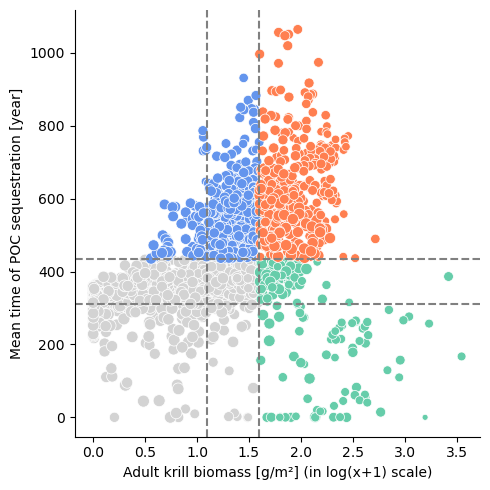

In [34]:
# fig = plt.figure(figsize=(8, 8)) 

sns.relplot(x="krill_adult_log", y="mean_seq_time", 
            data=zones_data_complete.sort_values(by='Zone_type'),# sort to improve lisibility
            hue='Zone_type',
            size='True_area',
            palette = ['lightgrey', 'cornflowerblue', 'mediumaquamarine', 'coral'],
            sizes = (15,75),
            legend=False)


plt.axvline(x=krill_quantile.iloc[0], color='grey', linestyle='--')
plt.axvline(x=krill_quantile.iloc[1], color='grey', linestyle='--')

plt.axhline(y=seq_quantile.iloc[0], color='grey', linestyle='--')
plt.axhline(y=seq_quantile.iloc[1], color='grey', linestyle='--')

plt.xlabel('Adult krill biomass [g/m²] (in log(x+1) scale)')
plt.ylabel('Mean time of POC sequestration [year]')

# plt.text(3.8, 400, '--- :  1/3 quantiles')

# saving in 'figure' folder
plt.tight_layout()
# plt.savefig('./figures/bi_plot_zones_typo.png', bbox_inches='tight', dpi=300)

plt.show()
